# Example 005: Using CMA-ES to perform previous optimizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iddefix
from scipy.constants import c

## Example 1: Analytical Resonator Fitting

Example used from first example notebook

### Modelling a three resonator impedance spectrum by three arbitrary resonators

Any arbitrary number of resonators can be initialized. This is example will demonstrate the creation of three resonators with the resonator Formulas functions inside `iddeficx` and later fitting.

Three random resonators ($R_s$, Q, $f_r$):

1. 400 $\Omega$, 30, 0.2 GHz
2. 1000 $\Omega$, 10, 1 GHz
3. 500 $\Omega$, 20, 1.75 GHz

In [2]:
# Assigning the resonator parameters

parameters = {
    "1": [400, 30, 0.2e9],
    "2": [1000, 10, 1e9],
    "3": [500, 20, 1.75e9],
}

# Computing the impedance spectrum for the resonators

frequency = np.linspace(0, 2e9, 1000)

impedance = iddefix.Impedances.n_Resonator_longitudinal_imp(frequency, parameters)

#### Plotting the impedance spectrum

Plots of both the real- and imaginary part of the impedance, as well as the absolute of the complex impedance 

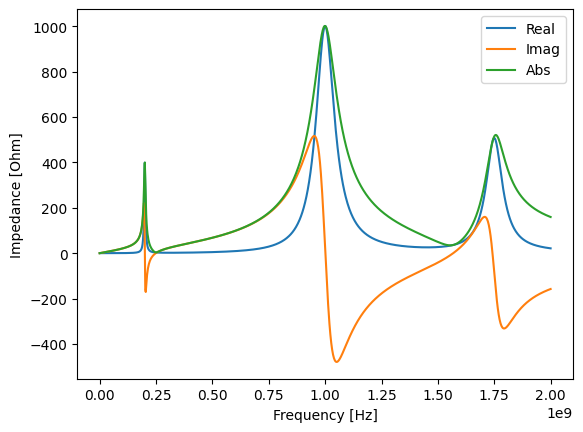

In [3]:
plt.plot(frequency, impedance.real, label="Real")
plt.plot(frequency, impedance.imag, label="Imag")
plt.plot(frequency, np.abs(impedance), label="Abs")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Impedance [Ohm]")
plt.legend()

### Fitting resonators with IDDEFIX on the absolute magnitude of the 3 resonator impdance spectrum

In [4]:
# Setting amount of resonators to fit

N_resonators = 3

# Bounds on resonators parameters
""" Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """

parameterBounds = [(0, 2000), (1, 1e3), (0.05e9, 2e9),
                   (0, 2000), (1, 1e3), (0.1e9, 2e9),
                   (0, 2000), (1, 1e3), (0.1e9, 2e9)]

#### Running IDDEFIX CMA-ES
Running the CMA-ES algorithm with IDDEFIX and chosen parameters.

In [5]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(
    frequency,
    impedance,
    N_resonators=N_resonators,
    parameterBounds=parameterBounds,
    plane="longitudinal",
    objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredError,
)

res = DE_model.run_differential_evolution(maxiter=3000,
                                          popsize=15,
                                          tol=0.01,
                                          mutation=(0.4, 1.0),
                                          crossover_rate=0.7)
print(DE_model.warning)

[!] Using the fully decayed resonator formalism for impedance


Differential Evolution:  46%|████▌     | 1387/3000 [00:17<00:20, 77.66gen/s, conv=102.6 %]




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        4.00e+02        |      30.00       |    2.000e+08     
    2     |        1.00e+03        |      10.00       |    1.000e+09     
    3     |        5.00e+02        |      20.00       |    1.750e+09     
----------------------------------------------------------------------
callback function requested stop early
CPU times: user 16.9 s, sys: 4.91 s, total: 21.8 s
Wall time: 17.9 s


In [6]:
%%time
CMAES_model = iddefix.EvolutionaryAlgorithm(
    frequency,
    impedance,
    N_resonators=N_resonators,
    parameterBounds=parameterBounds,
    plane="longitudinal",
    objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredError,
)

res = CMAES_model.run_cmaes(maxiter=1000, popsize=30, sigma=0.6)
print(CMAES_model.warning)

[!] Using the fully decayed resonator formalism for impedance
9
Starting point: [1.000e+03 5.005e+02 1.025e+09 1.000e+03 5.005e+02 1.050e+09 1.000e+03
 5.005e+02 1.050e+09]


CMA-ES evolution:  69%|██████▊   | 687/1000 [00:03<00:01, 190.56gen/s, conv=100.0 %]




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.00e+03        |      10.00       |    1.000e+09     
    2     |        5.00e+02        |      20.00       |    1.750e+09     
    3     |        4.00e+02        |      30.00       |    2.000e+08     
----------------------------------------------------------------------
Maximum iterations reached
CPU times: user 8.52 s, sys: 8.47 s, total: 17 s
Wall time: 5.94 s


### Assesing the fitting visually

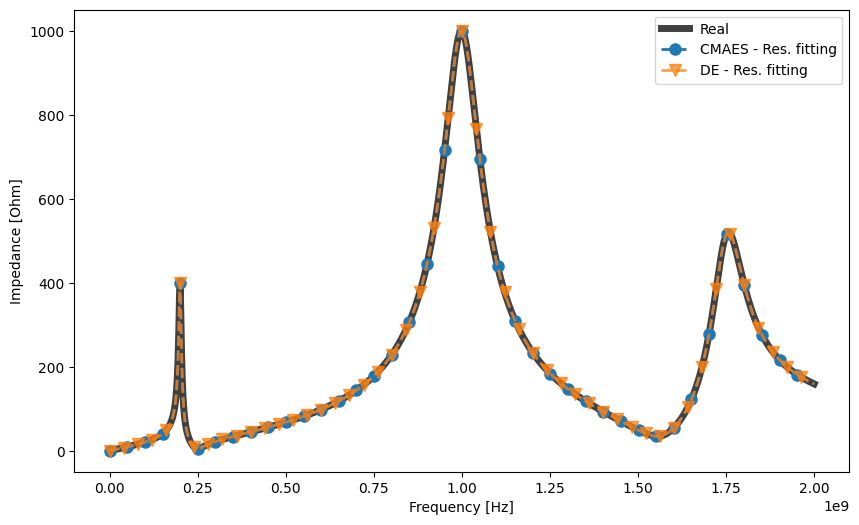

In [7]:
plt.figure(figsize=(10, 6))
result_CMAES = np.abs(CMAES_model.get_impedance(use_minimization=False))
result_DE = np.abs(DE_model.get_impedance(use_minimization=False))

plt.plot(frequency, np.abs(impedance), lw=5, label='Real', color='black', alpha=0.75)
plt.plot(frequency, result_CMAES,  lw=2, label='CMAES - Res. fitting', linestyle='--', marker='o', markevery=25, alpha=1, markersize=8)
plt.plot(frequency, result_DE,  lw=2, label='DE - Res. fitting', linestyle='--', marker='v', markevery=20, alpha=0.75, markersize=8)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()


## Example 2: Fitting SPS-BWS Simulation Data
From the third example notebook

## Simulation data example

This example features simulated wakefield data of the "Beam Wire Scanner" device.

## Fitting on fully decayed wakefield

### Import data

In [8]:
# Importing impedance data
data = np.loadtxt("data/003_beam_wire_scanner.txt", comments="#", delimiter="\t")

# Extracting frequency and impedance

frequency = data[:,0]*1e9 # Convert to GHz
abs_impedance = data[:,1]
imag_impedance = data[:,2]

impedance = abs_impedance + 1j*imag_impedance

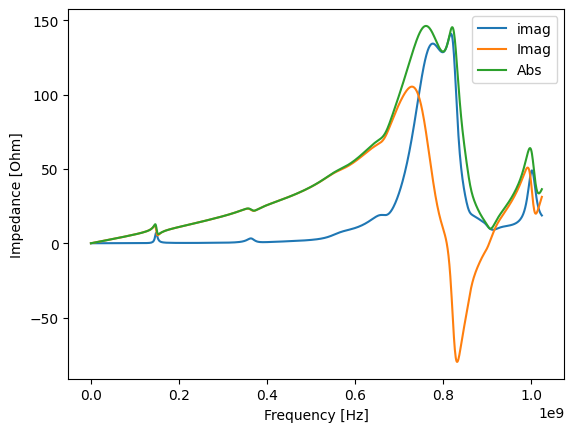

In [9]:
plt.plot(frequency, impedance.real, label='imag')
plt.plot(frequency, impedance.imag, label='Imag')
plt.plot(frequency, np.abs(impedance), label='Abs')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Impedance [Ohm]")
plt.legend()

For the beam wire scanner, the power loss due to the imag part of the impedance is crucial. Thus this example will demonstrate fitting upon the imag part, as opposed to the prior examples which fitted upon the absolute impedance magnitude

In [10]:
# Bounds on resonators parameters
""" In this example, we will use the SmartBoundDetermination class to determine the bounds on the resonators parameters.
By using SmartBoundDetermination ther is no need to specify the bounds manually."""

SBD_parameterBound = iddefix.SmartBoundDetermination(frequency, impedance.real, 
                                                    minimum_peak_height=2,  Q_bounds=[0.1, 5])

parameterBounds = SBD_parameterBound.find()

N_resonators = SBD_parameterBound.N_resonators

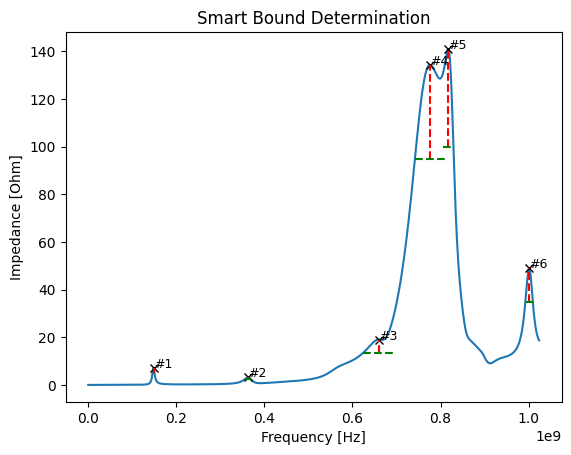

In [11]:
SBD_parameterBound.inspect()

In [12]:
SBD_parameterBound.to_table()


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |     5.64 to 70.54      |  7.25 to 362.50  |  1.38e+08 to 1.58e+08   
    2     |     2.61 to 32.61      |  2.96 to 147.92  |  3.53e+08 to 3.73e+08   
    3     |    15.23 to 190.40     |  0.90 to 44.79   |  6.50e+08 to 6.70e+08   
    4     |   107.43 to 1342.91    |  1.11 to 55.74   |  7.66e+08 to 7.86e+08   
    5     |   112.75 to 1409.35    |  3.63 to 181.36  |  8.07e+08 to 8.27e+08   
    6     |    39.21 to 490.08     |  6.11 to 305.62  |  9.91e+08 to 1.01e+09   
--------------------------------------------------------------------------------


#### Running IDDEFIX DE
Running the DE algorithm with IDDEFIX and chosen parameters.

In [17]:
CMAES_model = iddefix.EvolutionaryAlgorithm(frequency,
                                         impedance.real,
                                         N_resonators=N_resonators,
                                         parameterBounds=SBD_parameterBound.find(),
                                         plane="longitudinal",)

res = CMAES_model.run_cmaes(maxiter=2000, popsize=30, sigma=0.5)
print(CMAES_model.warning)

[!] Objective function set to `iddefix.objectiveFunctions.sumOfSquaredErrorReal` for real-valued only data
[!] Using the fully decayed resonator formalism for impedance
18
Starting point: [3.80923211e+01 1.84875000e+02 1.48467597e+08 1.76103368e+01
 7.54375000e+01 3.63489634e+08 1.02817005e+02 2.28437500e+01
 6.60424827e+08 7.25174044e+02 2.84250000e+01 7.76127162e+08
 7.61047133e+02 9.24954545e+01 8.17083740e+08 2.64644568e+02
 1.55868750e+02 1.00138834e+09]


CMA-ES evolution:  58%|█████▊    | 1162/2000 [00:09<00:07, 119.31gen/s, conv=100.0 %]




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.04e+00        |      21.68       |    1.483e+08     
    2     |        2.78e+00        |      19.09       |    3.616e+08     
    3     |        1.52e+01        |      10.82       |    6.504e+08     
    4     |        1.28e+02        |      10.97       |    7.661e+08     
    5     |        1.13e+02        |      26.98       |    8.155e+08     
    6     |        4.32e+01        |      36.04       |    1.001e+09     
----------------------------------------------------------------------
Maximum iterations reached


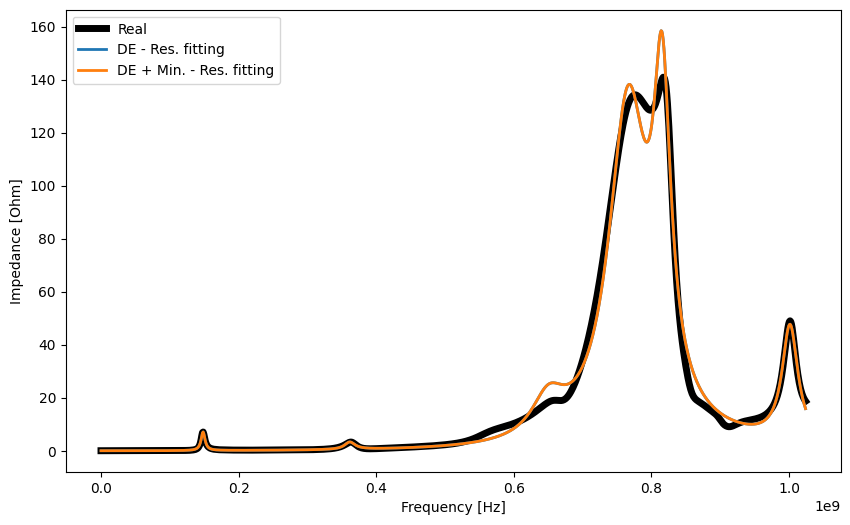

In [18]:
plt.figure(figsize=(10, 6))
result_DE = CMAES_model.get_impedance(use_minimization=False).real
result_DE_MIN = CMAES_model.get_impedance().real

plt.plot(frequency, impedance.real, lw=5, label="Real", color="black")
plt.plot(frequency, result_DE, lw=2, label="DE - Res. fitting")
plt.plot(frequency, result_DE_MIN, lw=2, label="DE + Min. - Res. fitting")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Impedance [Ohm]")
plt.legend()

## Example 3: Transverse wake extrapolation of SPS Transitions
> Using the impedance in frequency domain from the wake

From the fourth example notebook (4a)

### Import data & visualization

In [2]:
# Importing wake potential data
data_wake_potential = np.loadtxt(
    "data/004_SPS_model_transitions_q26.txt", comments="#", delimiter="\t"
)

# Extracting data
data_wake_time = data_wake_potential[:,0] *1e-9 # [s]
data_wake_dipolar = -data_wake_potential[:,2]

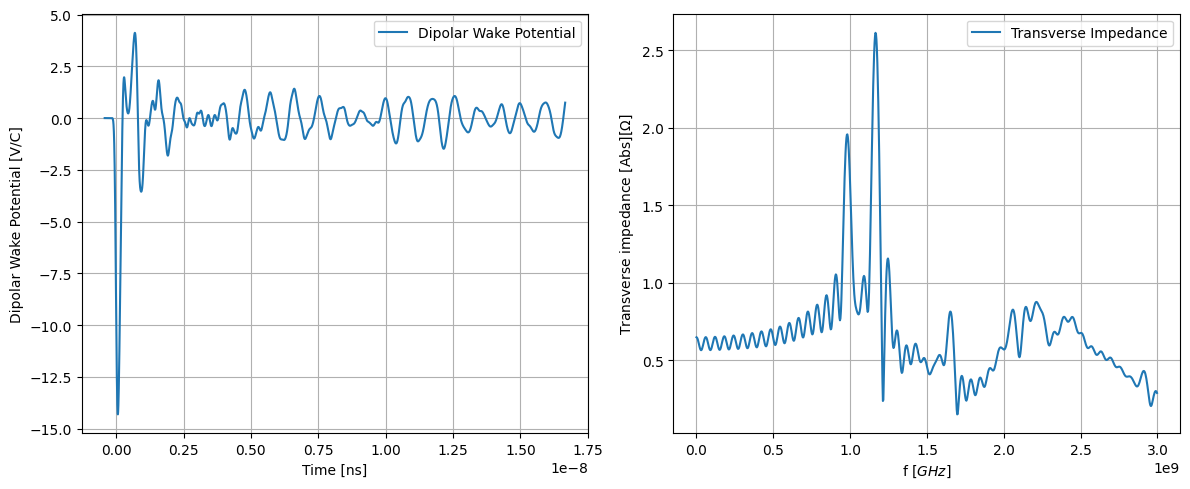

In [3]:
# Compute FFT to get Impedance
f, Z = iddefix.compute_fft(data_wake_time, data_wake_dipolar)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
axs[0].plot(data_wake_time, data_wake_dipolar, label="Dipolar Wake Potential")
axs[0].set_xlabel("Time [ns]")
axs[0].set_ylabel("Dipolar Wake Potential [V/C]")
axs[0].grid(True)
axs[0].legend()

# Plot frequency vs impedance on the right
axs[1].plot(f, np.abs(Z), label="Transverse Impedance")
axs[1].set_xlabel("f $[GHz]$")
axs[1].set_ylabel("Transverse impedance [Abs]$[\Omega]$")
axs[1].grid(True)
axs[1].legend()


plt.tight_layout()
plt.show()

### The problem of the broadband baseline
Extrapolating this impedance is tricky. This spectrum contains several coupled resonators, some with very broad resonator peaks and there seems to be a baseline as the impedance starts at 0.6 Ω. To investigate this ”baseline” a plot of impedances for different decay times is made:

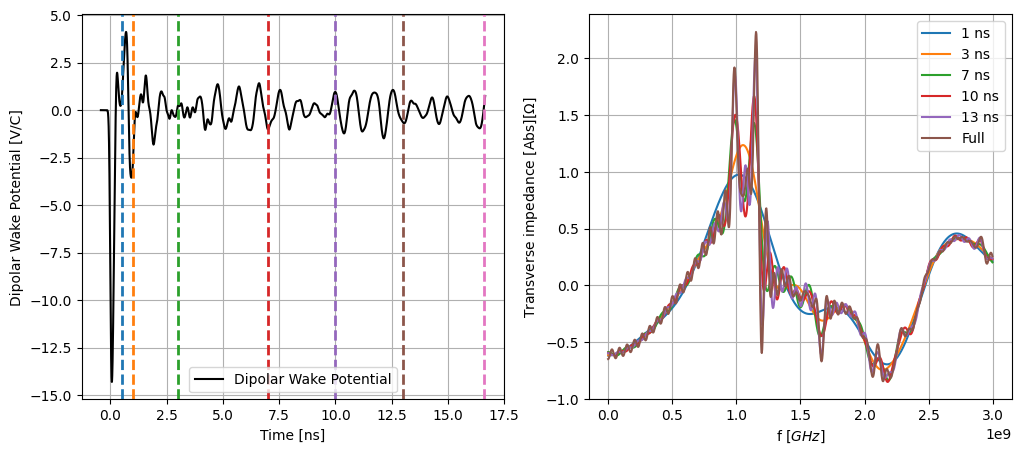

In [4]:
data_wake_dipolar_1ns = data_wake_dipolar[data_wake_time <= 1e-9]
data_wake_dipolar_3ns = data_wake_dipolar[data_wake_time <= 3e-9]
data_wake_dipolar_7ns = data_wake_dipolar[data_wake_time <= 7e-9]
data_wake_dipolar_10ns = data_wake_dipolar[data_wake_time <= 10e-9]
data_wake_dipolar_13ns = data_wake_dipolar[data_wake_time <= 13e-9]

_, Z_1ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_1ns)
_, Z_3ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_3ns)
_, Z_7ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_7ns)
_, Z_10ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_10ns)
_, Z_13ns = iddefix.compute_fft(data_wake_time, data_wake_dipolar_13ns)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
axs[0].plot(
    data_wake_time * 1e9, data_wake_dipolar, c="k", label="Dipolar Wake Potential"
)
axs[0].set_xlabel("Time [ns]")
axs[0].set_ylabel("Dipolar Wake Potential [V/C]")
axs[0].grid(True)
axs[0].legend()
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
]
lines = [0.5, 1.0, 3.0, 7.0, 10.0, 13.0, 16.6]
for i, line in enumerate(lines):
    axs[0].axvline(line, lw=2.0, ls="--", c=colors[i])

axs[1].plot(f, np.real(Z_1ns), label='1 ns')
axs[1].plot(f, np.real(Z_3ns), label='3 ns')
axs[1].plot(f, np.real(Z_7ns), label='7 ns')
axs[1].plot(f, np.real(Z_10ns), label='10 ns')
axs[1].plot(f, np.real(Z_13ns), label='13 ns')
axs[1].plot(f, np.real(Z), label='Full')
axs[1].set_xlabel('f $[GHz]$')
axs[1].set_ylabel('Transverse impedance [Abs]$[\Omega]$')
axs[1].grid(True)
axs[1].legend()

At 1 ns this baseline is well-established and strongly captured. Actually, the resonators develop and grow nicely from this blue curve. A decision is made to subtract this baseline and fit the resonators on the impedance data without the contribution from the first nanosecond of the model. The DE algorithm is run optimizing parameters for a total of 12 resonators on the baseline removed impedance data:

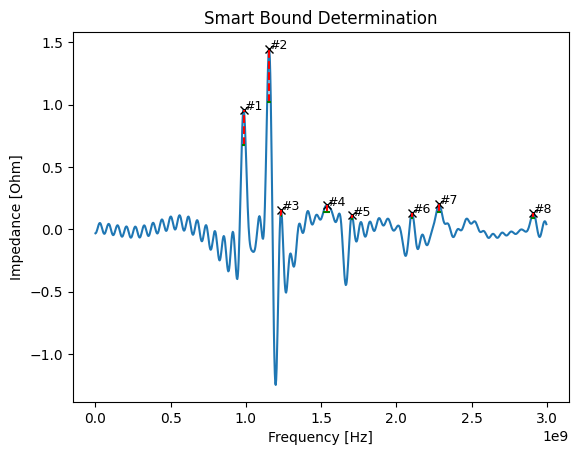


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |      0.77 to 9.59      | 20.50 to 205.00  |  9.75e+08 to 9.95e+08   
    2     |     1.16 to 14.47      | 24.00 to 240.00  |  1.14e+09 to 1.16e+09   
    3     |      0.12 to 1.53      |102.75 to 1027.50 |  1.22e+09 to 1.24e+09   
    4     |      0.15 to 1.92      | 16.00 to 160.00  |  1.53e+09 to 1.55e+09   
    5     |      0.09 to 1.12      | 71.00 to 710.00  |  1.70e+09 to 1.72e+09   
    6     |      0.11 to 1.34      | 87.62 to 876.25  |  2.10e+09 to 2.12e+09   
    7     |      0.16 to 2.01      | 47.56 to 475.62  |  2.28e+09 to 2.30e+09   
    8     |      0.10 to 1.30      | 60.56 to 605.62  |  2.90e+09 to 2.92e+09   
--------------------------------------------------------------------------------


In [5]:
heights = np.zeros_like(Z)
heights[f<2.e9] = 0.25
heights[f>=2.e9] = 0.05
heights[f>=2.5e9] = 0.1
baseline_removed = iddefix.SmartBoundDetermination(f, np.real(Z)-np.real(Z_1ns))
baseline_removed.find(minimum_peak_height=0.05, distance=10, prominence=0.19)
baseline_removed.inspect()
baseline_removed.to_table()

### Running IDDEFIX CMA-ES
Running the CMA-ES algorithm with IDDEFIX and chosen parameters.
One needs to supply the `wake_length` to the resonator formula to use the 
partially decayed wake variant.


In [17]:
# Total parameter bounds
N_resonators = baseline_removed.N_resonators
wake_length = data_wake_time[-1]*c # in [m]
parameterBounds = baseline_removed.parameterBounds 

In [19]:
CMAES_model = iddefix.EvolutionaryAlgorithm(f,
                                         np.real(Z)-np.real(Z_1ns),
                                         N_resonators=N_resonators,
                                         parameterBounds=parameterBounds,
                                         plane="transverse",
                                         wake_length=wake_length)

res = CMAES_model.run_cmaes(maxiter=2000, popsize=30, sigma=0.15)
print(CMAES_model.warning)

[!] Objective function set to `iddefix.objectiveFunctions.sumOfSquaredErrorReal` for real-valued only data
[!] Using the partially decayed resonator formalism for impedance
24
Starting point: [5.17613070e+00 1.12750000e+02 9.84986957e+08 7.81171363e+00
 1.32000000e+02 1.15315546e+09 8.28716582e-01 5.65125000e+02
 1.23423671e+09 1.03631944e+00 8.80000000e+01 1.53754062e+09
 6.07342528e-01 3.90500000e+02 1.70570912e+09 7.23104080e-01
 4.81937500e+02 2.10510932e+09 1.08741131e+00 2.61593750e+02
 2.28528986e+09 7.04332134e-01 3.33093750e+02 2.90991574e+09]


CMA-ES evolution:   0%|          | 5/2000 [03:03<20:19:07, 36.67s/gen, conv=0.0 %]




----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        4.34e+00        |      205.00      |    9.860e+08     
    2     |        6.37e+00        |      240.00      |    1.153e+09     
    3     |        2.60e-01        |     1027.50      |    1.239e+09     
    4     |        2.63e-01        |      39.23       |    1.546e+09     
    5     |        6.45e-01        |      710.00      |    1.707e+09     
    6     |        8.83e-01        |      876.25      |    2.103e+09     
    7     |        2.44e-01        |      84.13       |    2.283e+09     
    8     |        6.30e-01        |      605.62      |    2.908e+09     
----------------------------------------------------------------------
Convergence achieved


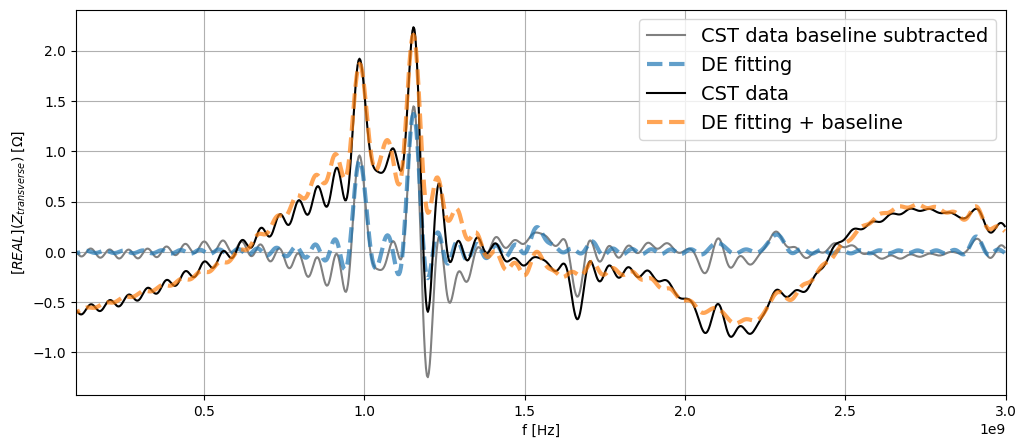

In [25]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(CMAES_model.frequency_data, np.real(CMAES_model.impedance_data),
         "grey", label='CST data baseline subtracted')

ax0.plot(CMAES_model.frequency_data, np.real(CMAES_model.get_impedance_from_fitFunction()),
         lw = 3, linestyle='--', label='DE fitting', alpha=0.7)

ax0.plot(CMAES_model.frequency_data, np.real(Z),
         "black", label='CST data')

ax0.plot(CMAES_model.frequency_data, np.real(Z_1ns)+np.real(CMAES_model.get_impedance_from_fitFunction()),
         lw = 3, linestyle='--', label='DE fitting + baseline', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$[REAL](Z_{transverse})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()



#plt.savefig("SPS_res_fitting_transverse.pdf", bbox_inches='tight')

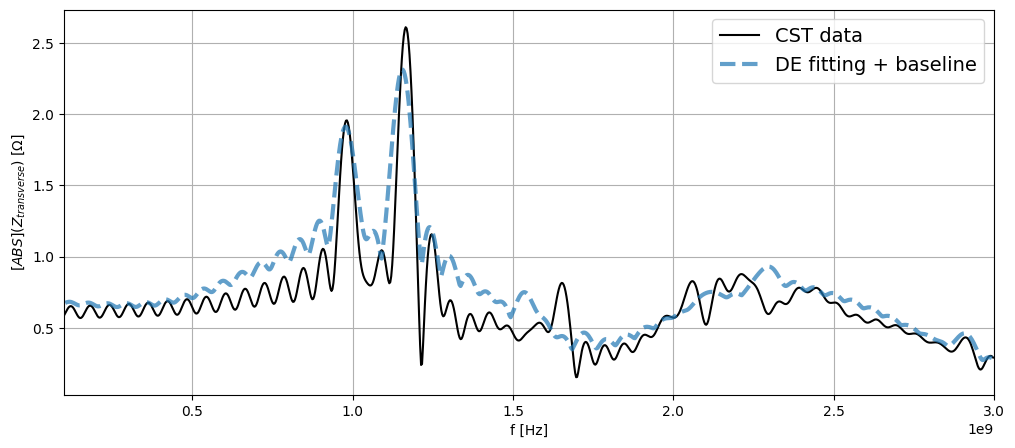

In [24]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(CMAES_model.frequency_data, np.abs(Z),
         "black", label='CST data')

ax0.plot(
    CMAES_model.frequency_data,
    np.abs(Z_1ns) + np.abs(CMAES_model.get_impedance_from_fitFunction()),
    lw=3,
    linestyle="--",
    label="DE fitting + baseline",
    alpha=0.7,
)

ax0.set_xlabel("f [Hz]")
ax0.set_ylabel("$[ABS](Z_{transverse})$ [$\Omega$]")
ax0.legend(loc="best", fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()


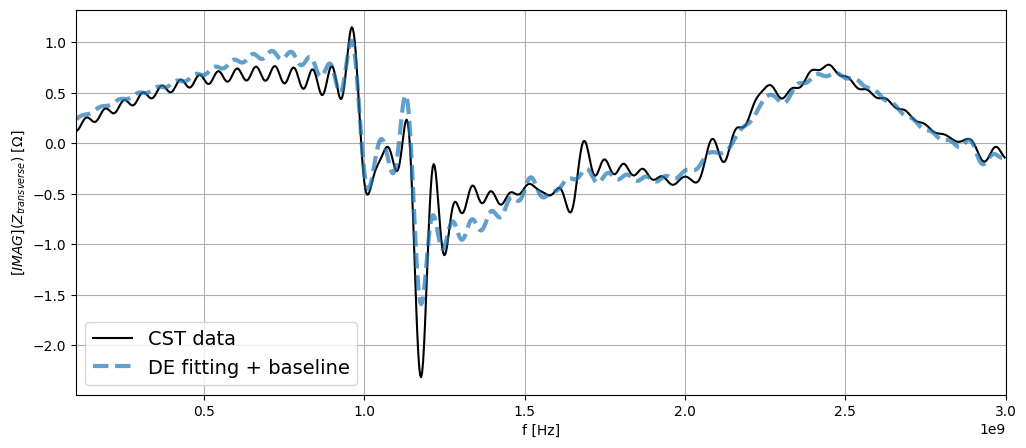

In [27]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(CMAES_model.frequency_data, np.imag(Z),
         "black", label='CST data')

ax0.plot(CMAES_model.frequency_data, np.imag(Z_1ns)+np.imag(CMAES_model.get_impedance_from_fitFunction()),
         lw = 3, linestyle='--', label='DE fitting + baseline', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$[IMAG](Z_{transverse})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()